In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

data = pd.read_csv(url, sep=';')

data = data[data['total sulfur dioxide']<200]

cols_to_z_score = data.keys()
cols_to_z_score = cols_to_z_score.drop('quality')

# for col in cols_to_z_score:
#     meanval = np.mean(data[col])
#     stdev = np.std(data[col], ddof=0)
#     data[col] = (data[col]-meanval) / stdev
data[cols_to_z_score] = data[cols_to_z_score].apply(stats.zscore)   

data['bool_quality'] = 0
data['bool_quality'][data['quality']>5] = 1

In [5]:
dataT = torch.tensor(data[cols_to_z_score].values).float()
labels = torch.tensor(data['bool_quality'].values).float()

labels = labels[:, None]

train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [6]:
class ANNWine(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11, 16)
        
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)
        
        self.output = nn.Linear(32, 1)
        
        
    def forward(self, x):
        
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
          
        return self.output(x)

In [7]:
num_of_epochs = 1000

def train_model():
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)
    
    train_acc = []
    test_acc = [] 
    losses = torch.zeros(num_of_epochs)
    
    for epoch in range(num_of_epochs):
        model.train()
        batch_acc = []
        batch_loss = []
        for X, y in train_loader:
            yHat = model(X)
            loss = loss_func(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            predlabels = yHat>0
            batch_acc.append(100*torch.mean((predlabels==y).float()).item())
            batch_loss.append(loss.item())
            
        train_acc.append(np.mean(batch_acc))
        losses[epoch] = np.mean(batch_loss)
        
        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            predlabels = model(X)>0
        test_acc.append(100*torch.mean((predlabels==y).float()).item())
    
    return train_acc, test_acc, losses

In [9]:
model = ANNWine()
train_acc, test_acc, losses = train_model()

In [10]:
train_predictions = model(train_loader.dataset.tensors[0])
train_predictions

test_predictions = model(test_loader.dataset.tensors[0])
test_predictions

tensor([[ 0.5775],
        [-5.8888],
        [ 1.3960],
        [ 0.3259],
        [ 2.1584],
        [-1.5375],
        [-2.2731],
        [ 4.6707],
        [-1.7686],
        [ 1.3385],
        [ 0.9034],
        [-0.2336],
        [ 5.1339],
        [-3.5000],
        [-5.3744],
        [-0.5018],
        [-2.7571],
        [ 0.2530],
        [ 4.1094],
        [-2.0019],
        [-2.7700],
        [ 1.6704],
        [-0.4206],
        [-0.4795],
        [-0.2503],
        [ 2.3615],
        [ 1.6831],
        [-3.6781],
        [ 1.2098],
        [ 7.0579],
        [ 0.4930],
        [ 3.2346],
        [-2.1419],
        [-1.4371],
        [-0.9692],
        [ 0.8519],
        [ 3.2520],
        [ 0.1677],
        [-1.9795],
        [ 5.0046],
        [-2.0218],
        [ 0.5471],
        [ 5.3752],
        [-3.1361],
        [ 1.5026],
        [ 0.4723],
        [ 0.1921],
        [ 3.3740],
        [ 3.2623],
        [-0.4485],
        [ 2.7006],
        [ 3.3131],
        [ 4.

In [11]:
import sklearn.metrics as skm

train_metrics = [0,0,0,0]
test_metrics = [0,0,0,0]

train_metrics[0] = skm.accuracy_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[2] = skm.recall_score(train_loader.dataset.tensors[1], train_predictions>0)
train_metrics[3] = skm.f1_score(train_loader.dataset.tensors[1], train_predictions>0)

test_metrics[0] = skm.accuracy_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[2] = skm.recall_score(test_loader.dataset.tensors[1], test_predictions>0)
test_metrics[3] = skm.f1_score(test_loader.dataset.tensors[1], test_predictions>0)

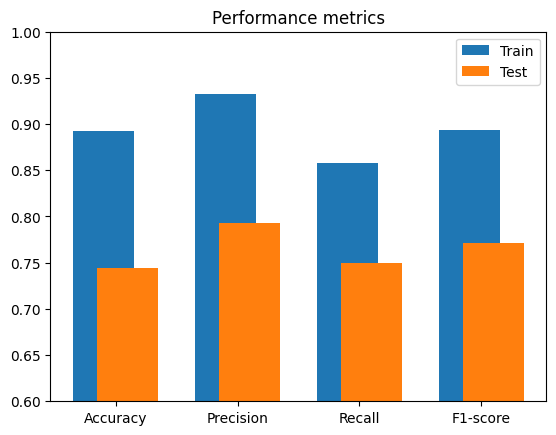

In [16]:
plt.bar(np.arange(4)-.1, train_metrics, .5)
plt.bar(np.arange(4)+.1, test_metrics, .5)
plt.xticks([0,1,2,3],['Accuracy', 'Precision', 'Recall', 'F1-score'])
plt.ylim([.6,1])
plt.legend(['Train', 'Test'])
plt.title('Performance metrics')
plt.show()

Text(1, 0, 'False positives:\n11.25%')

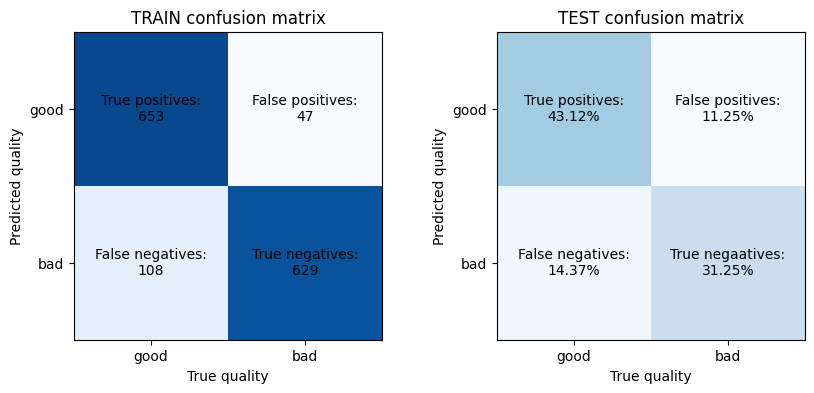

In [36]:
train_conf = skm.confusion_matrix(train_loader.dataset.tensors[1], train_predictions>0, labels=[1, 0]).T
test_conf = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0, labels=[1,0], normalize='all').T

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].imshow(train_conf, 'Blues', vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['good', 'bad'])
ax[0].set_yticklabels(['good', 'bad'])
ax[0].set_xlabel('True quality')
ax[0].set_ylabel('Predicted quality')
ax[0].set_title('TRAIN confusion matrix')

ax[0].text(0,0,f"True positives:\n{train_conf[0,0]}", ha='center', va='center')
ax[0].text(0,1,f"False negatives:\n{train_conf[1,0]}", ha='center', va='center')
ax[0].text(1,1,f"True negatives:\n{train_conf[1,1]}", ha='center', va='center')
ax[0].text(1,0,f"False positives:\n{train_conf[0,1]}", ha='center', va='center')

ax[1].imshow(test_conf, 'Blues', vmax=1)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['good', 'bad'])
ax[1].set_yticklabels(['good', 'bad'])
ax[1].set_xlabel('True quality')
ax[1].set_ylabel('Predicted quality')
ax[1].set_title('TEST confusion matrix')

ax[1].text(0,0,f"True positives:\n{round(test_conf[0,0]*100, 2)}%", ha='center', va='center')
ax[1].text(0,1,f"False negatives:\n{round(test_conf[1,0]*100, 2)}%", ha='center', va='center')
ax[1].text(1,1,f"True negaatives:\n{round(test_conf[1,1]*100, 2)}%", ha='center', va='center')
ax[1].text(1,0,f"False positives:\n{round(test_conf[0,1]*100, 2)}%", ha='center', va='center')